# MOUNTING DRIVE



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/AIDrivenSriLanka/

/content/drive/MyDrive/Colab Notebooks/AIDrivenSriLanka


In [ ]:
%ls

huggingface_tokenizers_cache/  llama-3-8b-Instruct-bnb-4bit-medical/  outputs/
InferenceMedLLM.ipynb          MedLLM.ipynb                           trainer_stats.json


# INSTALLING LIBRARIES

In [ ]:
!pip install xformers==0.0.27

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!pip install --no-deps packaging ninja einops flash-attn trl peft accelerate bitsandbytes
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 79.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Using cached ninja-1.11.1.1-py2.py3-none-manylinux1_x86_64.manylinux_2_5_x86_64.whl (307 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 17.0 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187290390 sha256=c50f5de67a8b75bcfcf4a34257622475f9b56d59da58a539476a21db9d5b9867
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash-attn
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-_45wk8kn/unsloth_254cebe8d6b64e3baf308e856b3bbf7a
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install

# Importing unsloth & other libraries

[Unsloth Github Repo](https://github.com/unslothai/unsloth)

In [ ]:
import json

import torch
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import TrainingArguments
from trl import SFTTrainer
from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [ ]:
notebook_login()

# Initializing LLM Fine-tuning Configurations

Defining the configuration for the base model, LoRA and training

Precision Levels: Precision refers to how much information is used to represent the numbers (weights, activations, etc.) in the model. Common precision levels include:


*   32-bit (FP32): This is full precision, where each number is represented by 32 bits. Most precise model, also the largest in size.

*   16-bit (FP16 or BF16): This is half precision, where each number is represented by 16 bits.

*   8-bit (INT8): This is even lower precision, with each number represented by 8 bits.

*   4-bit: This is an even more compressed representation, where each number is represented by just 4 bits. Aggresive drop in precision due to extended quantizing.

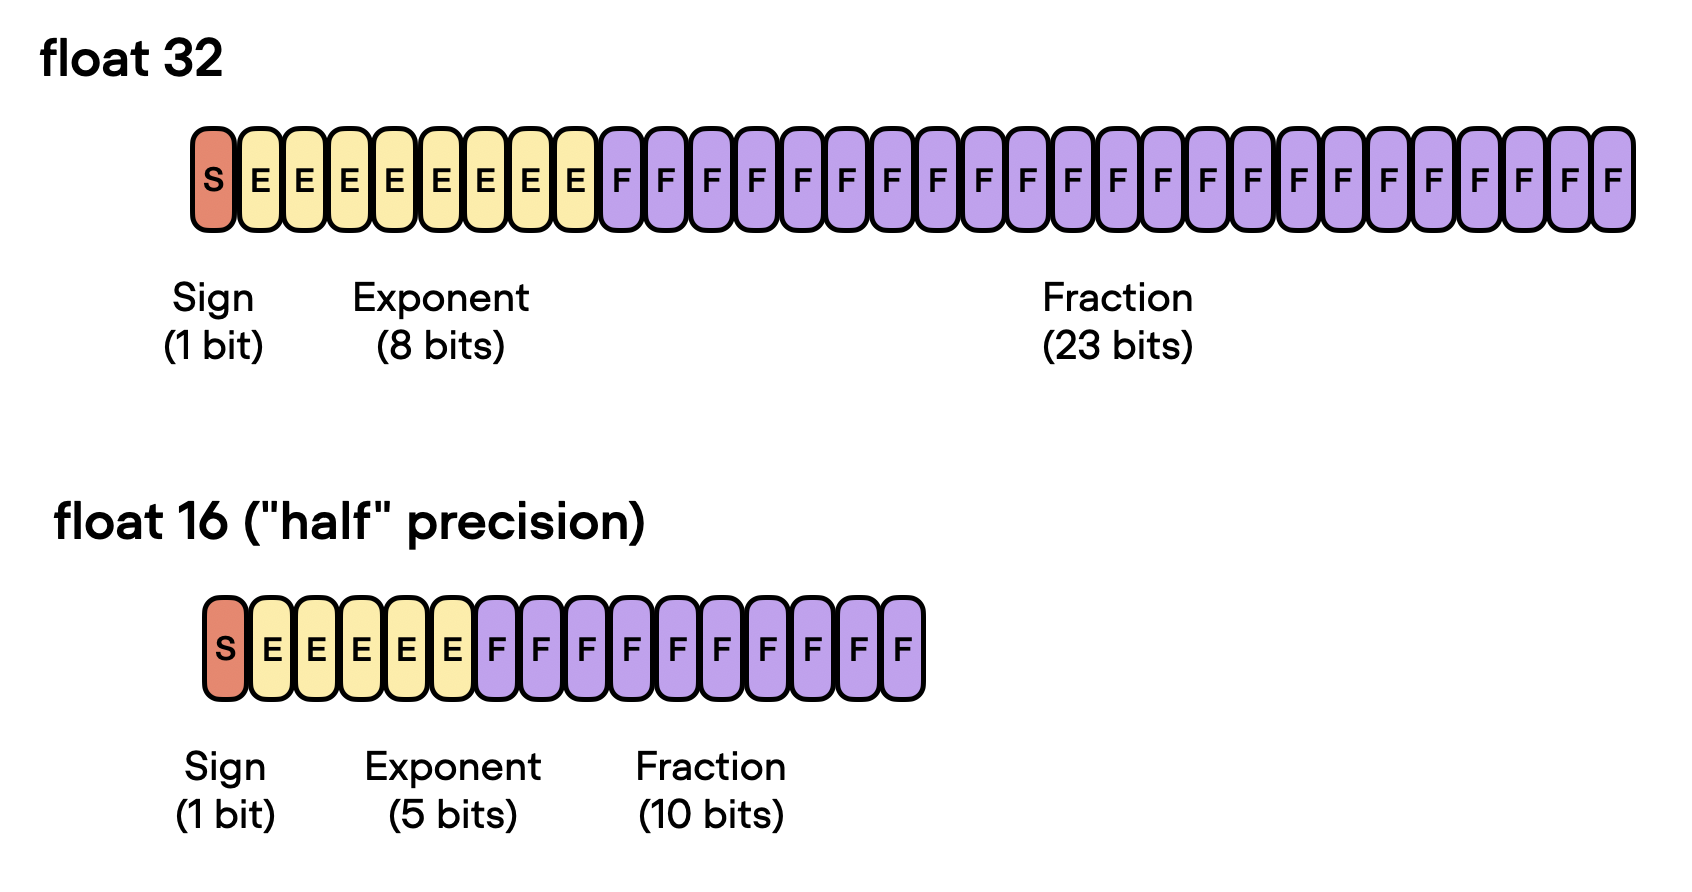

LoRA: adds small, low rank, matrices with fewer parameters to attention layers and fine-tunes these layers without focusing on the billion parameters.

[Dataset used](https://huggingface.co/datasets/Shekswess/medical_llama3_instruct_dataset_short/viewer/default/train?q=squamous+cell+carcinoma&p=5&row=689)

In [ ]:
config = {
    "hugging_face_username":"Shekswess",
    "model_config": {
        "base_model":"unsloth/llama-3-8b-Instruct-bnb-4bit", # Pre-trained, 4-bit version of Llama-3-8B
        "finetuned_model":"llama-3-8b-Instruct-bnb-4bit-medical", # The finetuned model name
        "max_seq_length": 2048, # The maximum sequence length / tokens the model can handle
        "dtype":torch.float16, # The data type used for computation, half of general computation
        "load_in_4bit": True,
    },
    "lora_config": {
      "r": 16, # The rank or number of LoRA layers
      "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"], # Modules targetted for fine-tuning
      "lora_alpha":16, # The alpha value for LoRA - controls the weight given to the parameters
      "lora_dropout":0, # Dropout value
      "bias":"none", # Bias
      "use_gradient_checkpointing":True,
      "use_rslora":False, # Other fine-tuning algorithms
      "use_dora":False, # Other fine-tuning algorithms
      "loftq_config":None
    },
    "training_dataset":{
        "name":"Shekswess/medical_llama3_instruct_dataset_short", # Dataset used
        "split":"train",
        "input_field":"prompt", # Column which must follow syntax for LLM and contains the user inputs
    },
    "training_config": {
        "per_device_train_batch_size": 2,
        "gradient_accumulation_steps": 4,
        "warmup_steps": 5,
        "max_steps":0,
        "num_train_epochs": 1,
        "learning_rate": 2e-4,
        "fp16": not torch.cuda.is_bf16_supported(),
        "bf16": torch.cuda.is_bf16_supported(),
        "logging_steps": 1, # To print logs while training
        "optim" :"adamw_8bit", # Optimizer : 8-bit version of ADAMW
        "weight_decay" : 0.01,
        "lr_scheduler_type": "linear",
        "seed" : 42, # The seed, to keep results consistent
        "output_dir" : "outputs", # Folder to output artifacts/metrics
    }
}

# Loading base/pre-trained model and tokenizer

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=config.get("model_config").get("base_model"),
    max_seq_length=config.get("model_config").get("max_seq_length"),
    dtype=torch.bfloat16 if config.get("training_config").get("bf16") else torch.float16,
    load_in_4bit=config.get("model_config").get("load_in_4bit"),
)

# Setup for LoRA PEFT of the base model

LoRA as a PEFT Method: LoRA is one specific example of a PEFT method. Parameter-Efficient Fine-Tuning refers to a broader class of techniques designed to fine-tune models with minimal changes to the original model parameters. The key idea behind PEFT methods is to achieve effective fine-tuning without the need to update all the model’s parameters, thereby reducing the resource requirements.

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = config.get("lora_config").get("r"),
    target_modules = config.get("lora_config").get("target_modules"),
    lora_alpha = config.get("lora_config").get("lora_alpha"),
    lora_dropout = config.get("lora_config").get("lora_dropout"),
    bias = config.get("lora_config").get("bias"),
    use_gradient_checkpointing = config.get("lora_config").get("use_gradient_checkpointing"),
    random_state = 42,
    use_rslora = config.get("lora_config").get("use_rslora"),
    use_dora = config.get("lora_config").get("use_dora"),
    loftq_config = config.get("lora_config").get("loftq_config"),
)

# Loading the training dataset

In [ ]:
dataset_train = load_dataset(config.get("training_dataset").get("name"), split = config.get("training_dataset").get("split"))


# Fine-tuning model using SFTTrainer with initialized configurations

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_train,
    dataset_text_field = config.get("training_dataset").get("input_field"),
    max_seq_length = config.get("model_config").get("max_seq_length"),
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = config.get("training_config").get("per_device_train_batch_size"),
        gradient_accumulation_steps = config.get("training_config").get("gradient_accumulation_steps"),
        warmup_steps = config.get("training_config").get("warmup_steps"),
        max_steps = config.get("training_config").get("max_steps"),
        num_train_epochs= config.get("training_config").get("num_train_epochs"),
        learning_rate = config.get("training_config").get("learning_rate"),
        fp16 = config.get("training_config").get("fp16"),
        bf16 = config.get("training_config").get("bf16"),
        logging_steps = config.get("training_config").get("logging_steps"),
        optim = config.get("training_config").get("optim"),
        weight_decay = config.get("training_config").get("weight_decay"),
        lr_scheduler_type = config.get("training_config").get("lr_scheduler_type"),
        seed = 42,
        output_dir = config.get("training_config").get("output_dir"),
    ),
)

# Training the model

*   Using 1 epoch (250 steps) due to runtime.
*   Broken down into 250 batches.
*   A lot faster with unsloth.

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 250
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,3.091900
2,3.484800
3,3.400200
4,2.561200
5,2.352300
6,1.861100
7,1.901200
8,1.781300
9,1.343700
10,1.719300


In [ ]:
with open("trainer_stats.json", "w") as f:
    json.dump(trainer_stats, f, indent=4)

# [
#     250,
#     1.239477121591568,
#     {
#         "train_runtime": 1027.0385, # Much faster with A100 (Colab PRO)
#         "train_samples_per_second": 1.947,
#         "train_steps_per_second": 0.243,
#         "total_flos": 2.937935225339904e+16,
#         "train_loss": 1.239477121591568,
#         "epoch": 1.0
#     }
# ]

# Locally saving the model and pushing it to the Hugging Face Hub (only LoRA adapters)

In [ ]:
model.save_pretrained(config.get("model_config").get("finetuned_model"))
model.push_to_hub(config.get("model_config").get("finetuned_model"), tokenizer = tokenizer)

README.md:   0%|          | 0.00/592 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/llama-3-8b-Instruct-bnb-4bit-medical


# Saving the model using merged_16bit(float16), merged_4bit(int4) or quantization options(q8_0, q4_k_m, q5_k_m)

* The way you save the model will depend on how you want to load it later.
* Best approach is to save it in the cloud.

In [ ]:
model.save_pretrained_merged(config.get("model_config").get("finetuned_model"), tokenizer, save_method = "merged_16bit",)
model.push_to_hub_merged(config.get("model_config").get("finetuned_model"), tokenizer, save_method = "merged_16bit")

# model.save_pretrained_merged(config.get("model_config").get("finetuned_model"), tokenizer, save_method = "merged_4bit",)
# model.push_to_hub_merged(config.get("model_config").get("finetuned_model"), tokenizer, save_method = "merged_4bit")

# model.save_pretrained_gguf(config.get("model_config").get("finetuned_model"), tokenizer)
# model.push_to_hub_gguf(config.get("model_config").get("finetuned_model"), tokenizer)

# model.save_pretrained_gguf(config.get("model_config").get("finetuned_model"), tokenizer, quantization_method = "f16")
# model.push_to_hub_gguf(config.get("model_config").get("finetuned_model"), tokenizer, quantization_method = "f16")

# model.save_pretrained_gguf(config.get("model_config").get("finetuned_model"), tokenizer, quantization_method = "q4_k_m")
# model.push_to_hub_gguf(config.get("model_config").get("finetuned_model"), tokenizer, quantization_method = "q4_k_m")

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 32.95 out of 52.96 RAM for saving.


100%|██████████| 32/32 [00:43<00:00,  1.35s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Done.
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 32.97 out of 52.96 RAM for saving.


100%|██████████| 32/32 [00:44<00:00,  1.39s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Done.
Saved merged model to https://huggingface.co/None/llama-3-8b-Instruct-bnb-4bit-medical


# Loading model locally for inferencing/testing

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = config.get("model_config").get("finetuned_model"),
        max_seq_length = config.get("model_config").get("max_seq_length"),
        dtype = config.get("model_config").get("dtype"),
        load_in_4bit = config.get("model_config").get("load_in_4bit"),
    )

FastLanguageModel.for_inference(model)

inputs = tokenizer(
[
    "[INST] Answer the question truthfully, you are a medical professional. This is the question: Can you provide an overview of the lung's squamous cell carcinoma? [/INST]"
], return_tensors = "pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True)
tokenizer.batch_decode(outputs, skip_special_tokens = True)


==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.0.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

["[INST] Answer the question truthfully, you are a medical professional. This is the question: Can you provide an overview of the lung's squamous cell carcinoma? [/INST] \n\nAs a medical professional, I'd be happy to provide an overview of squamous cell carcinoma of the lung.\n\nSquamous cell carcinoma (SCC) is a type of non-small cell lung cancer (NSCLC) that accounts for approximately 5-10% of all lung cancers. It is a malignant tumor that arises from the squamous cells lining the airways and alveoli of the lung.\n\nHere are some key characteristics of lung SCC:\n\n1. **Pathology**: SCC is characterized by the presence of squamous cells with keratinization, which is the formation of keratin, a protein that gives the skin its strength and elasticity. This process is often accompanied by the formation of keratin pearls, which are small clusters of keratin that resemble tiny pearls.\n2. **Clinical presentation**: Patients with lung SCC often present with symptoms such as coughing, chest

In [ ]:
inputs = tokenizer(
[
    "[INST] Answer the question truthfully, you are a medical professional. This is the question: What exactly is Marjolin's ulcer? [/INST]"
], return_tensors = "pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True)
tokenizer.batch_decode(outputs, skip_special_tokens = True)

["[INST] Answer the question truthfully, you are a medical professional. This is the question: What exactly is Marjolin's ulcer? [/INST] Marjolin's ulcer is a type of chronic, granulomatous ulcer that develops on the skin overlying a chronic, non-healing wound, such as a pressure ulcer, a burn, or a chronic open wound. It is caused by the chronic presence of bacteria, particularly Escherichia coli, in the wound. The bacteria stimulate an inflammatory response, which leads to the formation of granulation tissue and the development of an ulcer. Marjolin's ulcer is often seen in patients with chronic wounds, such as those with diabetes, spinal cord injuries, or other conditions that affect wound healing. It is a rare but serious complication of chronic wounds, and it can lead to significant morbidity and mortality if left untreated. Treatment of Marjolin's ulcer typically involves debridement of the wound, antibiotics, and wound care, as well as addressing any underlying causes of the chr

In [ ]:
inputs = tokenizer(
[
    "[INST] Answer the question truthfully, you are a medical professional. This is the question: What is (are) Li-Fraumeni syndrome ? [/INST]"
], return_tensors = "pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True)
tokenizer.batch_decode(outputs, skip_special_tokens = True)

['[INST] Answer the question truthfully, you are a medical professional. This is the question: What is (are) Li-Fraumeni syndrome? [/INST] Li-Fraumeni syndrome is a rare, autosomal dominant genetic disorder that increases the risk of developing various types of cancer, particularly breast cancer, soft tissue sarcomas, brain tumors, and adrenocortical carcinoma. The syndrome is caused by mutations in the TP53 gene, which is responsible for regulating cell growth and preventing the development of tumors. The TP53 gene is a tumor suppressor gene, and its mutations can lead to the development of cancer. Li-Fraumeni syndrome is often diagnosed in families with a history of multiple cases of cancer, particularly breast cancer and brain tumors, in multiple generations. The syndrome is typically characterized by the occurrence of cancer in young individuals, often before the age of 45. Treatment for Li-Fraumeni syndrome typically involves monitoring for cancer and undergoing regular screening 

# Other Fine-tuning Use Cases

*   Training a model on niche topics not found on the internet
*   Improving existing Generative AI use cases to better suit your audience/requirement

